In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn import metrics
import scipy.cluster.hierarchy as sch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,recall_score, precision_score, ConfusionMatrixDisplay
from sklearn import set_config
set_config(display="diagram")

I will use the 'ld' data for analysis and visualization.

The 'df' data will be used for modeling and predictions.

In [4]:
loan = '/content/lending_club_loan_dataset.csv'
ld = pd.read_csv(loan)
df = pd.read_csv(loan)
ld.head()

,id,grade,annual_inc,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,od_ratio,bad_loan
0,11454641,A,100000.0,1,1,RENT,26.27,credit_card,36 months,1,NaN,43.2,0.0,0.160624,0
1,9604874,A,83000.0,0,4,OWN,5.39,credit_card,36 months,0,NaN,21.5,0.0,0.810777,0
2,9684700,D,78000.0,0,11,MORTGAGE,18.45,debt_consolidation,60 months,1,NaN,46.3,0.0,0.035147,1
3,9695736,D,37536.0,0,6,MORTGAGE,12.28,medical,60 months,0,NaN,10.7,0.0,0.534887,1
4,9795013,D,65000.0,0,11,MORTGAGE,11.26,debt_consolidation,36 months,0,NaN,15.2,0.0,0.166500,0


In [5]:
ld.duplicated().sum()

0

In [6]:
ld.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     20000 non-null  int64  
 1   grade                  20000 non-null  object 
 2   annual_inc             20000 non-null  float64
 3   short_emp              20000 non-null  int64  
 4   emp_length_num         20000 non-null  int64  
 5   home_ownership         18509 non-null  object 
 6   dti                    19846 non-null  float64
 7   purpose                20000 non-null  object 
 8   term                   20000 non-null  object 
 9   last_delinq_none       20000 non-null  int64  
 10  last_major_derog_none  574 non-null    float64
 11  revol_util             20000 non-null  float64
 12  total_rec_late_fee     20000 non-null  float64
 13  od_ratio               20000 non-null  float64
 14  bad_loan               20000 non-null  int64  
dtypes:

In [7]:
ld.isna().sum()

id                           0
grade                        0
annual_inc                   0
short_emp                    0
emp_length_num               0
home_ownership            1491
dti                        154
purpose                      0
term                         0
last_delinq_none             0
last_major_derog_none    19426
revol_util                   0
total_rec_late_fee           0
od_ratio                     0
bad_loan                     0
dtype: int64

Remove the "last_major_derog_none" column from the dataset due to a large 
portion of missing data.

In [8]:
ld = ld.drop(columns=['last_major_derog_none','id'])

In [9]:
ld['home_ownership'].value_counts()

MORTGAGE    9844
RENT        7052
OWN         1613
Name: home_ownership, dtype: int64

Use the most frequent value in the "home_ownership" column for missing data.

In [10]:
ld['home_ownership'].fillna('MORTGAGE', inplace=True)

Use the mean value of the "dti" column for missing data for consistency.

In [11]:
ld['dti'].fillna(ld['dti'].mean(), inplace=True)
ld.isna().sum()

grade                 0
annual_inc            0
short_emp             0
emp_length_num        0
home_ownership        0
dti                   0
purpose               0
term                  0
last_delinq_none      0
revol_util            0
total_rec_late_fee    0
od_ratio              0
bad_loan              0
dtype: int64

In [12]:
categories = ["grade", "annual_inc", "short_emp", "emp_length_num",
              "home_ownership", "dti", "purpose", "term", "last_delinq_none",
              "revol_util", "total_rec_late_fee", "od_ratio", "bad_loan"]
for values in categories:
  print("\n", values)
  print(ld[values].value_counts())


 grade
B    6042
C    5566
D    3554
A    2159
E    1645
F     865
G     169
Name: grade, dtype: int64

 annual_inc
60000.0     787
50000.0     735
65000.0     609
70000.0     608
80000.0     548
           ... 
112711.0      1
66389.0       1
62212.0       1
44289.0       1
93250.0       1
Name: annual_inc, Length: 2566, dtype: int64

 short_emp
0    17750
1     2250
Name: short_emp, dtype: int64

 emp_length_num
11    6530
3     1732
4     1501
1     1453
6     1405
8     1316
7     1246
2     1227
5     1026
9      989
0      797
10     778
Name: emp_length_num, dtype: int64

 home_ownership
MORTGAGE    11335
RENT         7052
OWN          1613
Name: home_ownership, dtype: int64

 dti
16.587841    154
15.870000     20
19.640000     20
11.450000     19
19.250000     19
            ... 
33.270000      1
3.180000       1
2.630000       1
33.440000      1
32.530000      1
Name: dti, Length: 3296, dtype: int64

 purpose
debt_consolidation    12337
credit_card            4137
home_improv

Fix inconsistency in "term" column

In [13]:
ld['term'] = ld['term'].replace([' 36 Months'], ' 36 months')
ld['term'].value_counts()

 36 months    15001
 60 months     4999
Name: term, dtype: int64

In [14]:
ld.dtypes

grade                  object
annual_inc            float64
short_emp               int64
emp_length_num          int64
home_ownership         object
dti                   float64
purpose                object
term                   object
last_delinq_none        int64
revol_util            float64
total_rec_late_fee    float64
od_ratio              float64
bad_loan                int64
dtype: object

The graphs below show the count for all numerical data in the dataset.
We can identify the outliers in these graphs by the difference of one value
when compared to the other values.

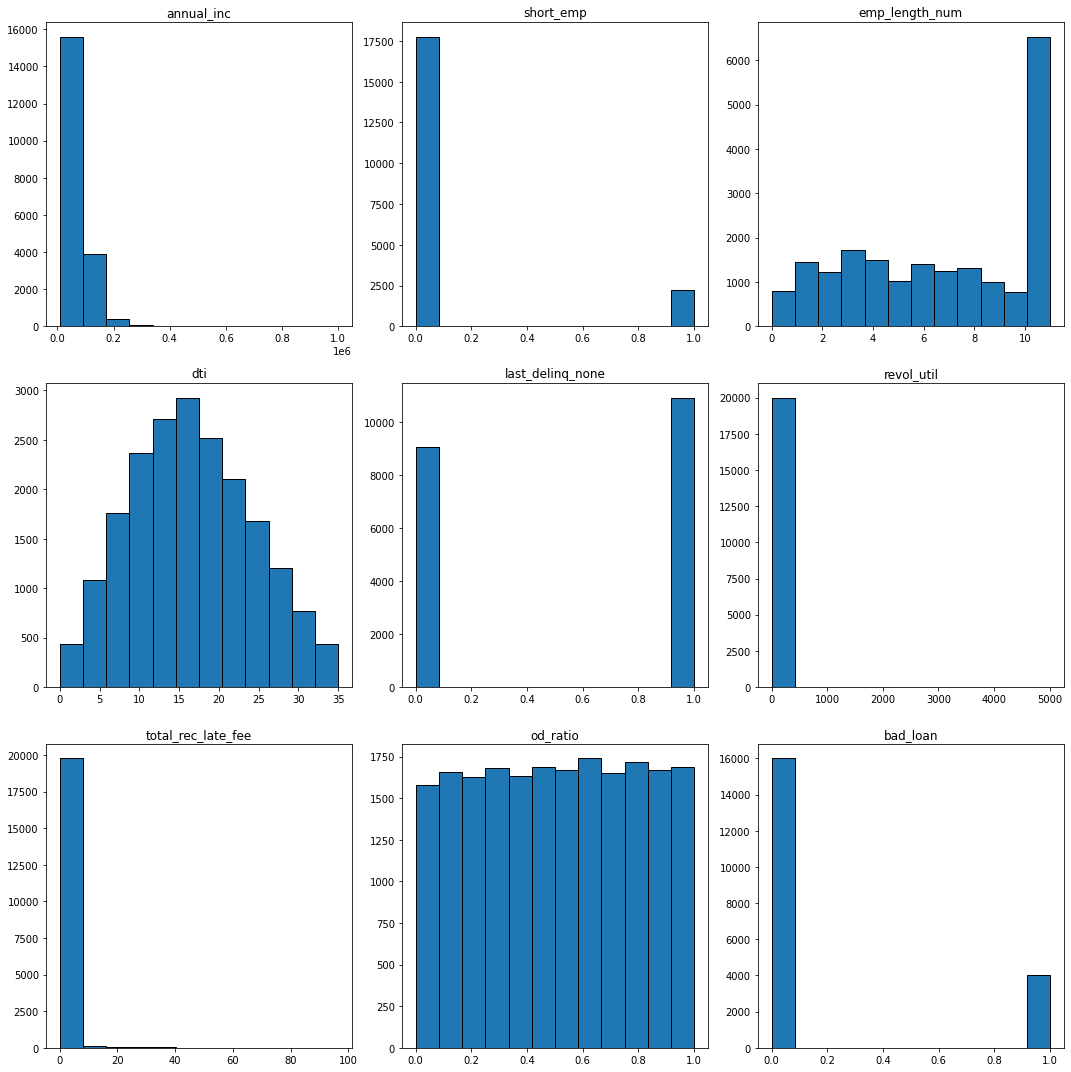

In [15]:
ld.hist(figsize=(15,15), bins=12, ec='black', grid=False)
plt.tight_layout()
plt.savefig('NumHistColumns.png', bbox_inches = "tight")

The graphs below show the count for all categorical data in the dataset.
We can identify the outliers in these graphs by the difference of one value
when compared to the other values.

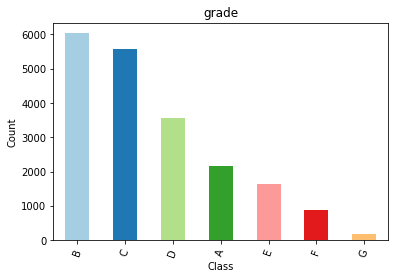

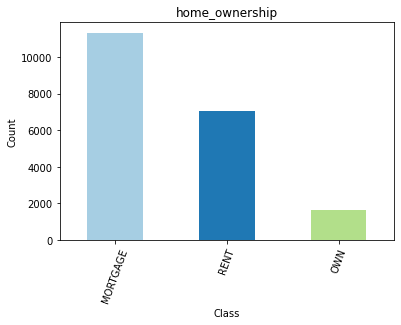

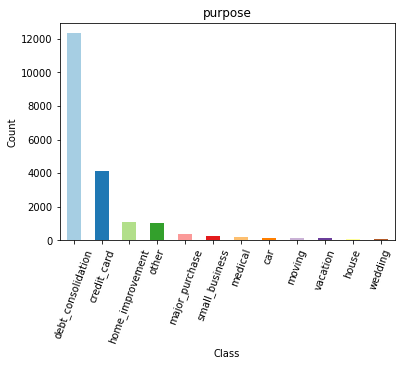

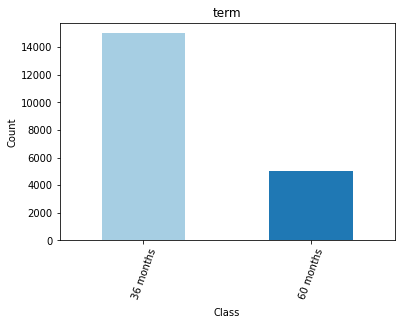

<Figure size 432x288 with 0 Axes>

In [16]:
for column in ld.select_dtypes(include=['object']).columns:
  ld[column].value_counts().plot(kind='bar', color=sns.color_palette('Paired'))

  plt.xlabel('Class')
  plt.xticks(rotation=70, horizontalalignment='center')
  plt.ylabel('Count')
  plt.title(column)
  plt.show()
  plt.savefig('CatHistColumns.png', bbox_inches = "tight")

The heatmap below show the correlation between both the target and features in the dataset. We can see the greatest correlations between bad_loan and the features would be dti and total_rec_late_fee. Though these features are not significantly correlated to the target, they would affect the results of the target more than other features. 

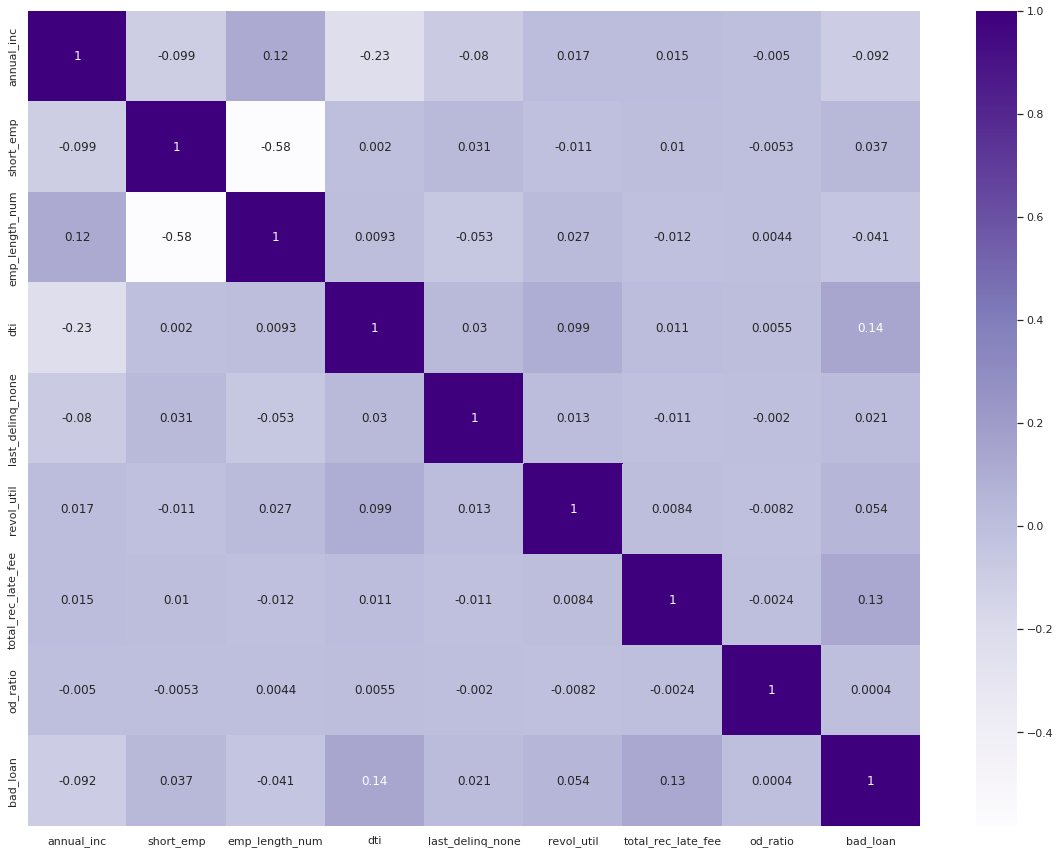

In [17]:
sns.set(rc = {'figure.figsize':(20,15)})
sns.heatmap(ld.corr(), cmap ="Purples", annot=True);
plt.savefig('Correlation.png', bbox_inches = "tight")

The boxplot below show the correlation between the annual income and grade features with each grade separated by terms. From the data, we can determine most of our data consists of customers with low annual incomes with a few outliers with high annual incomes of various grades.

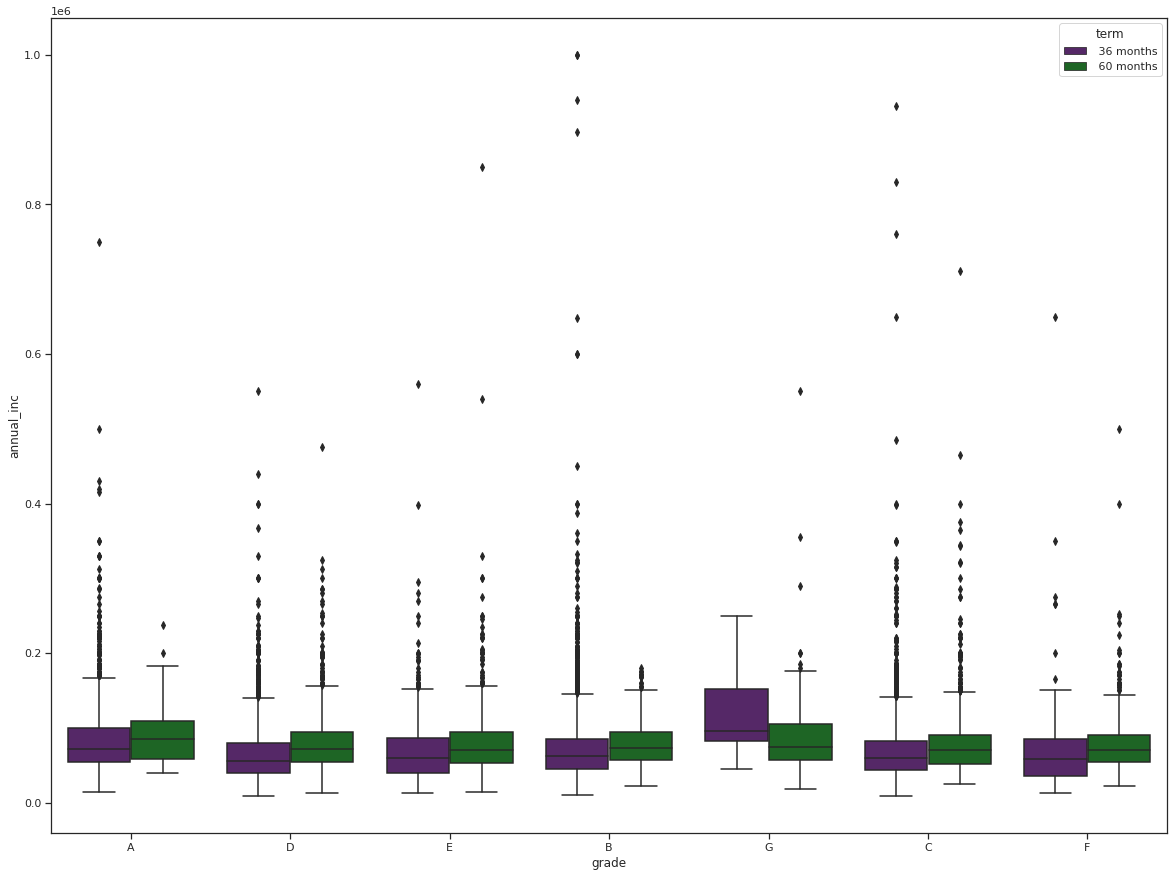

In [18]:
sns.set_theme(style='ticks',palette='dark')
sns.boxplot(x='grade', y='annual_inc', hue='term', data=ld, palette=['m','g']);
plt.savefig('BoxGradeTerms.png', bbox_inches = "tight")

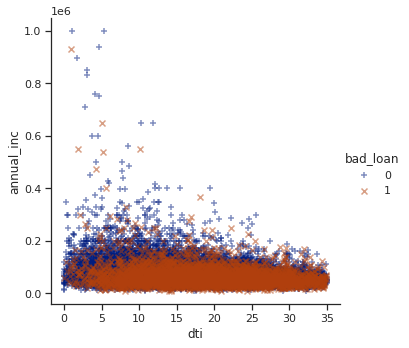

In [19]:
sns.lmplot(x='dti', y='annual_inc', markers=['+','x'], hue='bad_loan', 
           data=ld.loc[ld['bad_loan'].isin([0, 1])],
           scatter_kws={'alpha':0.5}, fit_reg=False);
plt.savefig('AnnualIncDTI.png', bbox_inches = "tight")

The scatterplot above shows the correlation between the debt-to-income and annual income features with each being marked based on those who defaulted on their loan. From the data, we can determine many low income customers defaulted on their loan no matter if their debt-to-income ratio is high or low. However, as the annual income increases, we can notice the debt-to-income is less and less customers defaulted on their loan. Stakeholders should be aware many of those with lower debt-to-income ratio and a higher salary will not default their loan.

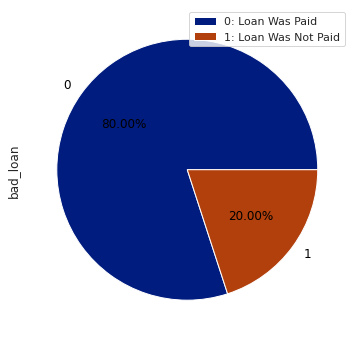

In [20]:
ld['bad_loan'].value_counts().plot(kind='pie', subplots=True, autopct='%1.2f%%', 
                                   legend=True, fontsize=12, figsize=(14,6), 
                                   textprops={'color':"black"})
plt.legend(["0: Loan Was Paid","1: Loan Was Not Paid"])
plt.show;
plt.savefig('BadLoanPie.png', bbox_inches = "tight")

The pie chart above shows the percentage of defaulted loans based on the dataset. As we can see, 80% of customers paid their loan off, while 20% of customers did not pay their loan off. Stakeholders can use this data to identify a ratio of customers who pay their loan off or not. 